In [1]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

import cv2
from  torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
'''
0 -> 2
1 -> 0
2 -> 1
3 -> 3
'''

gpu_number = 1
device = torch.device(device=f'cuda:{gpu_number}')
device

device(type='cuda', index=1)

In [3]:
DATASET_PATH = Path('/') / 'DATA' / 'vvikhrov' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [104]:
class task1_dataset(Dataset):
    def __init__(self, data_packs, split = 'train'):
        assert split in ['train', 'test']
        self.data_packs = data_packs
        self.indices = []
        self.device = device
        
        if split == 'train':
            for i, data_pack in enumerate(data_packs):
                for j in range(len(data_pack)):
                    if not data_pack[j].is_test_split():
                        self.indices.append((i, j))
        else:
            for i, data_pack in enumerate(data_packs):
                for j in range(len(data_pack)):
                    if data_pack[j].is_test_split():
                        self.indices.append((i, j))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        i, j = self.indices[idx]
        dp = self.data_packs[i][j]
        image = np.array(dp.image.convert('RGB')) / 255.
        mask = cv2.fillConvexPoly(np.zeros(image.shape[:2]), np.array(dp.gt_data['quad']), (1,))[np.newaxis, ...]
        return torch.tensor(image.transpose(2, 0, 1), dtype=torch.float, device=device),\
                torch.tensor(mask, dtype=torch.float, device=device)
    
    def unique_key(self, idx):
        i, j = self.indices[idx]
        dp = self.data_packs[i][j]
        return dp.unique_key

In [105]:
val_data = task1_dataset(data_packs, split='test')
len(val_data)

4250

In [5]:
train_data = task1_dataset(data_packs, 'train') # TODO: transform
val_data = task1_dataset(data_packs, 'test')

In [6]:
batch_size=4
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [7]:
class enc_conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.block(x)

In [8]:
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.dec_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, u, e):
        '''
        padding trick source:
        https://github.com/xiaopeng-liao/Pytorch-UNet/blob/master/unet/unet_parts.py
        (the rest is my code from another course)
        '''
        u = self.upsample(u)
        pad_w = e.shape[2] - u.shape[2]
        pad_h = e.shape[3] - u.shape[3]
        padding = [pad_h // 2, pad_h - pad_h // 2, pad_w // 2, pad_w - pad_w // 2]
#         print(e.shape, u.shape)
#         print(padding)
        u = nn.functional.pad(u, padding)
        return self.dec_conv(torch.cat((e, u), dim=1))

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.enc_conv0 = enc_conv_block(3, 64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = enc_conv_block(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = enc_conv_block(128, 256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = enc_conv_block(256, 512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = enc_conv_block(512, 1024)

        # decode
        self.up_0 = upsample_block(1024+512, 512)
        self.up_1 = upsample_block(512+256, 256)
        self.up_2 = upsample_block(256+128, 128)
        self.up_3 = upsample_block(128+64, 64)
        
        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) 

        # decoder
        u0 = self.up_0(b, e3)
        u1 = self.up_1(u0, e2)
        u2 = self.up_2(u1, e1)
        u3 = self.up_3(u2, e0)
        
        out = self.out(u3)
        return out
unet_model = UNet().to(device)

In [10]:
from time import time

In [11]:
from IPython.display import clear_output

In [12]:
clear_output(wait=True)

In [20]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in tqdm(data_tr):

            opt.zero_grad()
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss.item())
        
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu()

        val_loss_sum = 0
        for X_val_batch, Y_val_batch in tqdm(data_val):
            with torch.set_grad_enabled(False):
                Y_pred_batch = model(X_val_batch)
                loss = loss_fn(torch.sigmoid(Y_pred_batch), Y_val_batch)
                prediction = torch.sigmoid(Y_pred_batch) > 0.5
            val_loss_sum += loss
        val_loss.append((val_loss_sum/len(data_val)).item())

        clear_output(wait=True)
        plt.figure(figsize = (16, 7))
        plt.title('Loss')
        plt.plot(train_loss, label='train loss')
        plt.plot(val_loss, label='val loss')
        plt.legend()
        plt.show()

        clear_output(wait=True)

        for k in range(4):
            plt.subplot(2, 4, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'epoch{epoch}.pth')

    return train_loss, val_loss

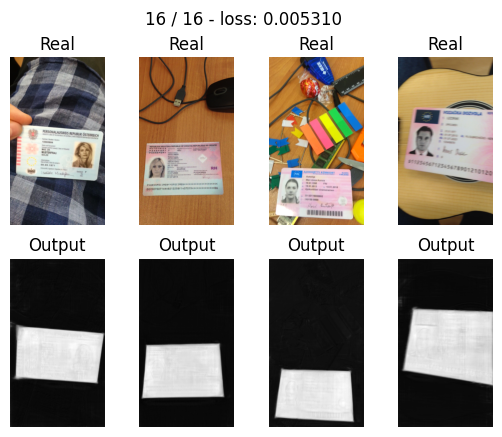

In [21]:
unet_train_loss, unet_val_loss = train(unet_model, torch.optim.Adam(unet_model.parameters()), nn.BCELoss(), 16, train_dl, val_dl)

In [26]:
torch.save(unet_model.state_dict(), 'final.pth')

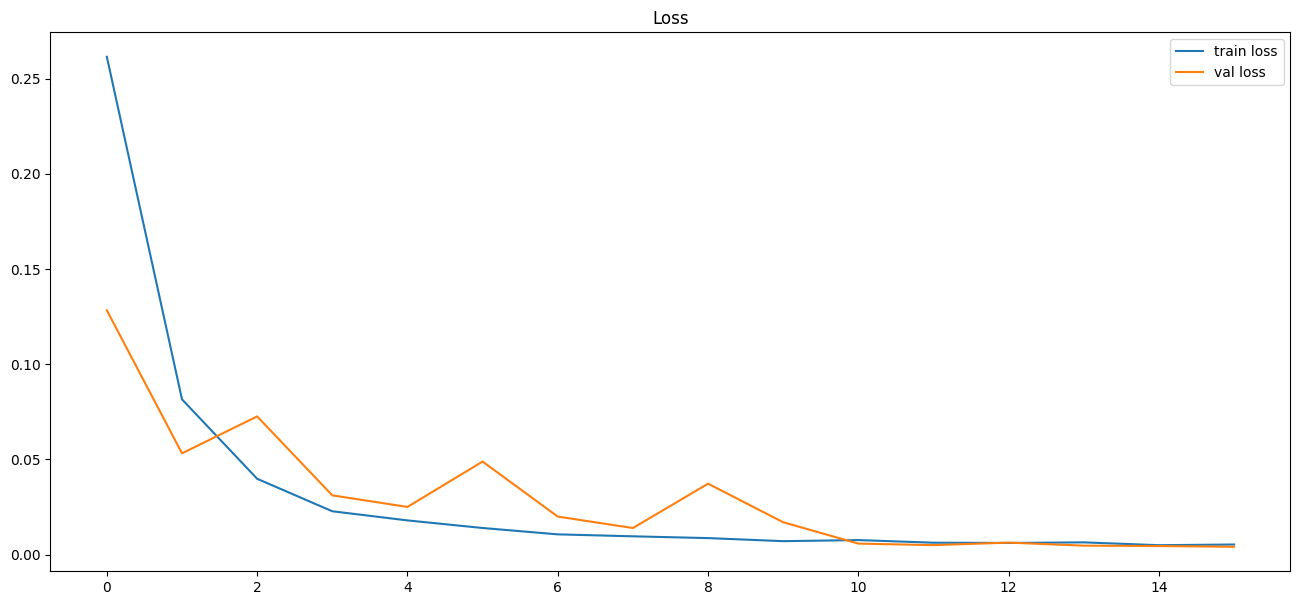

In [24]:
plt.figure(figsize = (16, 7))
plt.title('Loss')
plt.plot(unet_train_loss, label='train loss')
plt.plot(unet_val_loss, label='val loss')
plt.legend()
plt.show()

In [25]:
unet_train_loss, unet_val_loss

([0.2615063190460205,
  0.08157382160425186,
  0.03983641415834427,
  0.022772006690502167,
  0.017974859103560448,
  0.013980359770357609,
  0.010639774613082409,
  0.009609890170395374,
  0.008673510514199734,
  0.007068456616252661,
  0.007629557978361845,
  0.006254487670958042,
  0.0061300103552639484,
  0.0064351786859333515,
  0.004943346604704857,
  0.00531035428866744],
 [0.1283208280801773,
  0.05320602282881737,
  0.07258663326501846,
  0.031129678711295128,
  0.025050204247236252,
  0.04887475073337555,
  0.019977984949946404,
  0.013969630002975464,
  0.037249766290187836,
  0.017003338783979416,
  0.005783723667263985,
  0.004984976723790169,
  0.0063024964183568954,
  0.0047081708908081055,
  0.004513314459472895,
  0.0041158972308039665])

In [17]:
del unet_model

In [49]:
torch.cuda.empty_cache()

In [13]:
unet_model.load_state_dict(torch.load('final.pth'))

<All keys matched successfully>

In [11]:
for X_val_batch, Y_val_batch in tqdm(val_dl):
    result = unet_model(X_val_batch)
    break

  0%|          | 0/2688 [00:00<?, ?it/s]

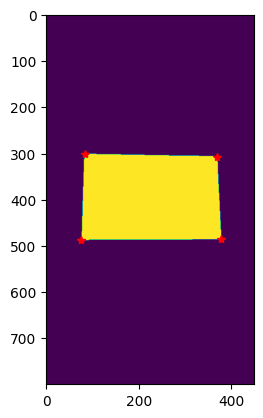

In [77]:
mask = torch.sigmoid(result[0][0].cpu().detach()) > 0.5

nonzero = mask.nonzero()
sums = nonzero.sum(axis=1)
top_left = nonzero[sums.argmin()]
bottom_right = nonzero[sums.argmax()]
diffs = nonzero[:, 0] - nonzero[:, 1]
top_right = nonzero[diffs.argmin()]
bottom_left = nonzero[diffs.argmax()]

plt.imshow(mask)
plt.plot(top_left[1], top_left[0], 'r*')
plt.plot(bottom_right[1], bottom_right[0], 'r*')

plt.plot(top_right[1], top_right[0], 'r*')
plt.plot(bottom_left[1], bottom_left[0], 'r*')

In [56]:
def get_vertices(prediction):
    mask = torch.sigmoid(prediction.cpu().detach()) > 0.5
    nonzero = mask.nonzero()
    sums = nonzero.sum(axis=1)
    top_left = nonzero[sums.argmin()]
    bottom_right = nonzero[sums.argmax()]
    diffs = nonzero[:, 0] - nonzero[:, 1]
    top_right = nonzero[diffs.argmin()]
    bottom_left = nonzero[diffs.argmax()]
    return torch.stack([top_left, top_right, bottom_right, bottom_left]).numpy().astype(float)

In [106]:
results_dict = dict()

for idx in tqdm(range(len(val_data))):
    image, _ = val_data[idx]
    result = unet_model(image.unsqueeze(0))[0][0]
    vertices = get_vertices(result)
    vertices[:, 0] /= result.shape[0]
    vertices[:, 1] /= result.shape[1]
    vertices[:, [0, 1]] = vertices[:, [1, 0]]
    key = val_data.unique_key(idx)
    results_dict[key] = vertices

  0%|          | 0/4250 [00:00<?, ?it/s]

In [55]:
i, j = val_data.indices[0]
dp = val_data.data_packs[i][j]
dp.gt_data

{'quad': [[27, 271], [385, 300], [394, 522], [1, 508]]}

In [109]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [110]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [111]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json',
    
)

/home/vvikhrov/course_cvdl/task_project/vikhrovvs_venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/vvikhrov/course_cvdl/task_project/vikhrovvs_venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/vvikhrov/course_cvdl/task_project/vikhrovvs_venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/vvikhrov/course_cvdl/task_project/vikhrovvs_venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/vvikhrov/course_cvdl/task_project/vikhrovvs_venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value 

In [112]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.7774
